<a href="https://www.kaggle.com/code/poojav21/amazon-review-sentiment-analysis?scriptVersionId=174439474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon/amazon_reviews.csv


**Read in Data And Import Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
plt.style.use('ggplot')
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

2024-04-28 10:12:19.444897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 10:12:19.445079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 10:12:19.621878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
df = pd.read_csv('/kaggle/input/amazon/amazon_reviews.csv')

In [4]:
df.head

<bound method NDFrame.head of       Unnamed: 0  reviewerName  overall  \
0              0           NaN      4.0   
1              1          0mie      5.0   
2              2           1K3      4.0   
3              3           1m2      5.0   
4              4  2&amp;1/2Men      5.0   
...          ...           ...      ...   
4910        4910        ZM "J"      1.0   
4911        4911            Zo      5.0   
4912        4912     Z S Liske      5.0   
4913        4913      Z Taylor      5.0   
4914        4914           Zza      5.0   

                                             reviewText  reviewTime  day_diff  \
0                                            No issues.  2014-07-23       138   
1     Purchased this for my device, it worked as adv...  2013-10-25       409   
2     it works as expected. I should have sprung for...  2012-12-23       715   
3     This think has worked out great.Had a diff. br...  2013-11-21       382   
4     Bought it with Retail Packaging, arrived l

In [5]:
df.columns

Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [7]:
df.nunique(axis = 0)

Unnamed: 0              4915
reviewerName            4594
overall                    5
reviewText              4912
reviewTime               690
day_diff                 690
helpful_yes               23
helpful_no                17
total_vote                26
score_pos_neg_diff        27
score_average_rating      28
wilson_lower_bound        40
dtype: int64

In [8]:
df.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [9]:
df = df[df['reviewerName'].notnull()]
df = df[df['reviewText'].notnull()]

In [10]:
df.isnull().sum()

Unnamed: 0              0
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

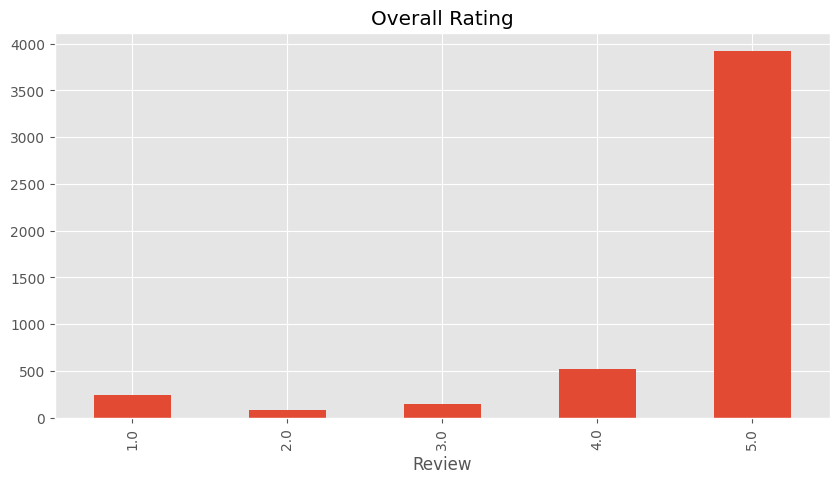

In [11]:
ad = df['overall'].value_counts().sort_index().plot(kind = 'bar', title = "Overall Rating", figsize = (10,5))
ad.set_xlabel("Review")
plt.show()

<Axes: title={'center': 'Avg. Rating'}, xlabel='score_average_rating'>

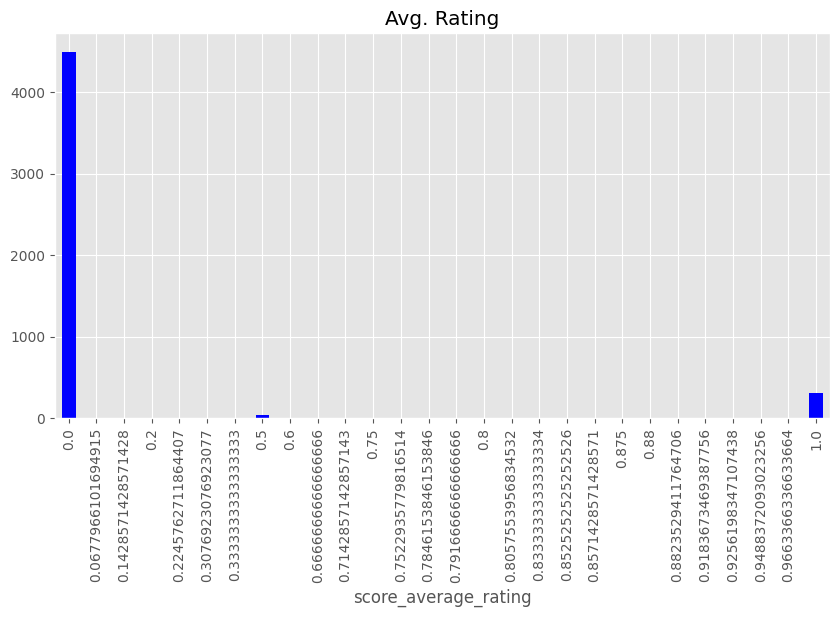

In [12]:
df['score_average_rating'].value_counts().sort_index().plot(kind = 'bar', title = "Avg. Rating", figsize = (10,5), color = 'blue')

<Axes: title={'center': 'Number of votes given to the evaluation'}, xlabel='total_vote'>

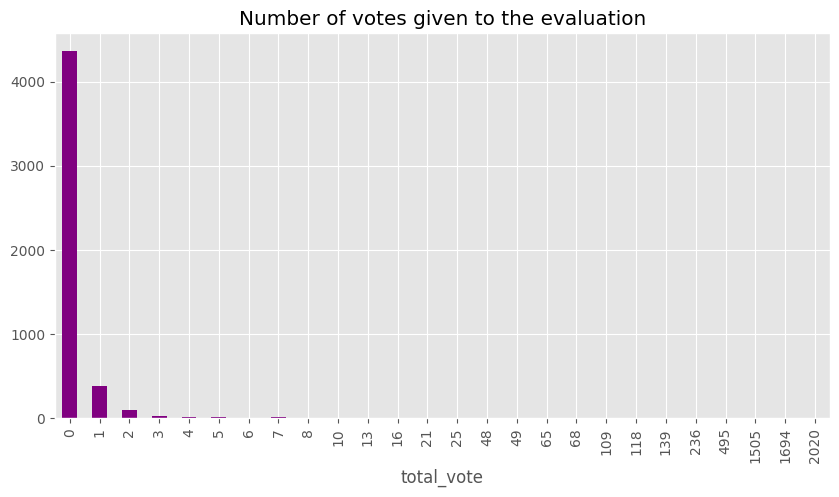

In [13]:
df['total_vote'].value_counts().sort_index().plot(kind = 'bar', title = 'Number of votes given to the evaluation', figsize = (10,5), color = 'purple')

In [14]:
for i in df:
    if i == 'reviewText':
        df[i] = df[i].str.lower()
        df[i] = df[i].str.replace('[^\w\s]', '')
        df[i] = df[i].str.replace('\d', '')
        
df
    

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
1,1,0mie,5.0,"purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. i should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,this think has worked out great.had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"bought it with retail packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
5,5,2Cents!,5.0,it's mini storage. it doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,4910,"ZM ""J""",1.0,i bought this sandisk 16gb class 10 to use wit...,2013-07-23,503,0,0,0,0,0.0,0.0
4911,4911,Zo,5.0,used this for extending the capabilities of my...,2013-08-22,473,0,0,0,0,0.0,0.0
4912,4912,Z S Liske,5.0,great card that is very fast and reliable. it ...,2014-03-31,252,0,0,0,0,0.0,0.0
4913,4913,Z Taylor,5.0,good amount of space for the stuff i want to d...,2013-09-16,448,0,0,0,0,0.0,0.0


In [15]:
old_name = 'Unnamed: 0'
new_name = 'ID'

df = df.rename(columns = {old_name:new_name})
df.head()


,ID,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
1,1,0mie,5.0,"purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. i should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,this think has worked out great.had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"bought it with retail packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
5,5,2Cents!,5.0,it's mini storage. it doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


In [16]:
df

,ID,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
1,1,0mie,5.0,"purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. i should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,this think has worked out great.had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"bought it with retail packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
5,5,2Cents!,5.0,it's mini storage. it doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,4910,"ZM ""J""",1.0,i bought this sandisk 16gb class 10 to use wit...,2013-07-23,503,0,0,0,0,0.0,0.0
4911,4911,Zo,5.0,used this for extending the capabilities of my...,2013-08-22,473,0,0,0,0,0.0,0.0
4912,4912,Z S Liske,5.0,great card that is very fast and reliable. it ...,2014-03-31,252,0,0,0,0,0.0,0.0
4913,4913,Z Taylor,5.0,good amount of space for the stuff i want to d...,2013-09-16,448,0,0,0,0,0.0,0.0


In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [18]:
sia = SentimentIntensityAnalyzer()

In [19]:
df['reviewText'][10]

'i like this sd card because it can take music video downloads, personal videos, files,docs, and multimedia images with a fast transfer rate of class 10 speed. it can take games with large files very easily and still have enough space for apps. it&#34;s great for video cameras and camcorders with the supplied adapter. fits very easily into smartphones and tablets sd card slots. i recommend this 32gb sd card to everyone.'

In [20]:
sia.polarity_scores(df['reviewText'][10])

{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.9258}

In [21]:
df.columns

Index(['ID', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff',
       'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff',
       'score_average_rating', 'wilson_lower_bound'],
      dtype='object')

In [22]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['reviewText']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/4913 [00:00<?, ?it/s]

In [23]:
pd.DataFrame(res).T

,neg,neu,pos,compound
1,0.075,0.925,0.000,-0.2960
2,0.077,0.923,0.000,-0.3089
3,0.000,0.909,0.091,0.7081
4,0.038,0.835,0.127,0.7087
5,0.000,1.000,0.000,0.0000
...,...,...,...,...
4910,0.091,0.817,0.092,0.0018
4911,0.000,0.939,0.061,0.1761
4912,0.000,0.828,0.172,0.8588
4913,0.000,0.802,0.198,0.4939


In [24]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'ID'})
vaders = vaders.merge(df, how = 'left')

In [25]:
vaders

,ID,neg,neu,pos,compound,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0.075,0.925,0.000,-0.2960,0mie,5.0,"purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,0.077,0.923,0.000,-0.3089,1K3,4.0,it works as expected. i should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,0.000,0.909,0.091,0.7081,1m2,5.0,this think has worked out great.had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,0.038,0.835,0.127,0.7087,2&amp;1/2Men,5.0,"bought it with retail packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,0.000,1.000,0.000,0.0000,2Cents!,5.0,it's mini storage. it doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,4910,0.091,0.817,0.092,0.0018,"ZM ""J""",1.0,i bought this sandisk 16gb class 10 to use wit...,2013-07-23,503,0,0,0,0,0.0,0.0
4909,4911,0.000,0.939,0.061,0.1761,Zo,5.0,used this for extending the capabilities of my...,2013-08-22,473,0,0,0,0,0.0,0.0
4910,4912,0.000,0.828,0.172,0.8588,Z S Liske,5.0,great card that is very fast and reliable. it ...,2014-03-31,252,0,0,0,0,0.0,0.0
4911,4913,0.000,0.802,0.198,0.4939,Z Taylor,5.0,good amount of space for the stuff i want to d...,2013-09-16,448,0,0,0,0,0.0,0.0


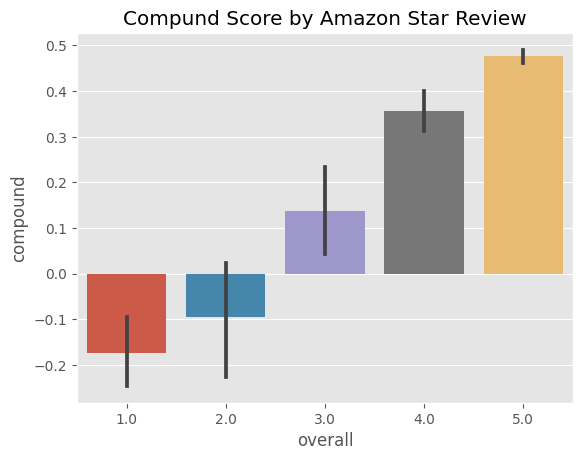

In [26]:
gph = sns.barplot(data = vaders, x = 'overall', y = 'compound')
gph.set_title('Compund Score by Amazon Star Review')
plt.show()

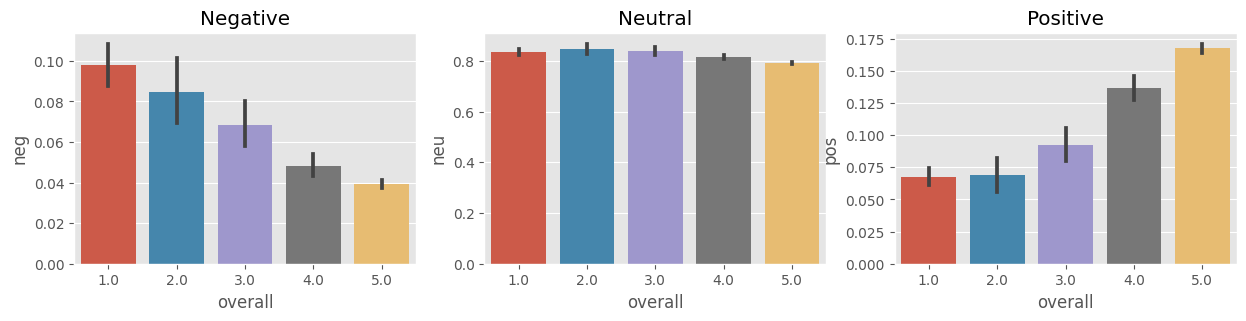

In [27]:
fig, ax = plt.subplots(1,3, figsize = (15,3))
sns.barplot(data = vaders, x = 'overall', y = 'neg', ax = ax[0])
sns.barplot(data = vaders, x = 'overall', y = 'neu', ax = ax[1])
sns.barplot(data = vaders, x = 'overall', y = 'pos', ax = ax[2])
ax[0].set_title('Negative')
ax[1].set_title('Neutral')
ax[2].set_title('Positive')
plt.show()

**Roberta Pretrained Model**

This is a roBERTa-base model trained on ~58M tweets and finetuned for sentiment analysis with the TweetEval benchmark. This model is suitable for English (for a similar multilingual model)



In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
Model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(Model)
model = AutoModelForSequenceClassification.from_pretrained(Model)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [30]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberat_pos' : scores[2]
    }
    return scores_dict
polarity_scores_roberta("This is too good")

{'roberta_neg': 0.00286469,
 'roberta_neu': 0.010610025,
 'roberat_pos': 0.9865253}

In [31]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['reviewText']
        myid = row['ID']
        vader_results = sia.polarity_scores(text)
        vader_results_rename = {}
        for key, value in vader_results.items():
            vader_results_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)
        combine = {**vader_results, **roberta_results}
        res[myid] = combine
    except Exception as e:
        print(f"Error processing ID {myid}: {e}")
    

  0%|          | 0/4913 [00:00<?, ?it/s]

Error processing ID 76: The expanded size of the tensor (1092) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1092].  Tensor sizes: [1, 514]
Error processing ID 123: The expanded size of the tensor (1183) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1183].  Tensor sizes: [1, 514]
Error processing ID 722: The expanded size of the tensor (757) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 757].  Tensor sizes: [1, 514]
Error processing ID 1380: The expanded size of the tensor (587) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 587].  Tensor sizes: [1, 514]
Error processing ID 2031: The expanded size of the tensor (1430) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1430].  Tensor sizes: [1, 514]
Error processing ID 2799: The expanded size of the tensor (637) must match the existing size (514) at non-si

In [32]:
results = pd.DataFrame(res).T
results = results.reset_index().rename(columns = {'index':'ID'})
results = results.merge(df, how = 'left')


In [33]:
results.head()

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberat_pos,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0.075,0.925,0.000,-0.2960,0.006695,0.084906,0.908400,0mie,5.0,"purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,0.077,0.923,0.000,-0.3089,0.382924,0.465266,0.151811,1K3,4.0,it works as expected. i should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,0.000,0.909,0.091,0.7081,0.002420,0.018434,0.979146,1m2,5.0,this think has worked out great.had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,0.038,0.835,0.127,0.7087,0.003562,0.060882,0.935556,2&amp;1/2Men,5.0,"bought it with retail packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,0.000,1.000,0.000,0.0000,0.106499,0.518373,0.375128,2Cents!,5.0,it's mini storage. it doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


**Comparing the Models**
Vader & Roberta

In [34]:
results.columns

Index(['ID', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberat_pos', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

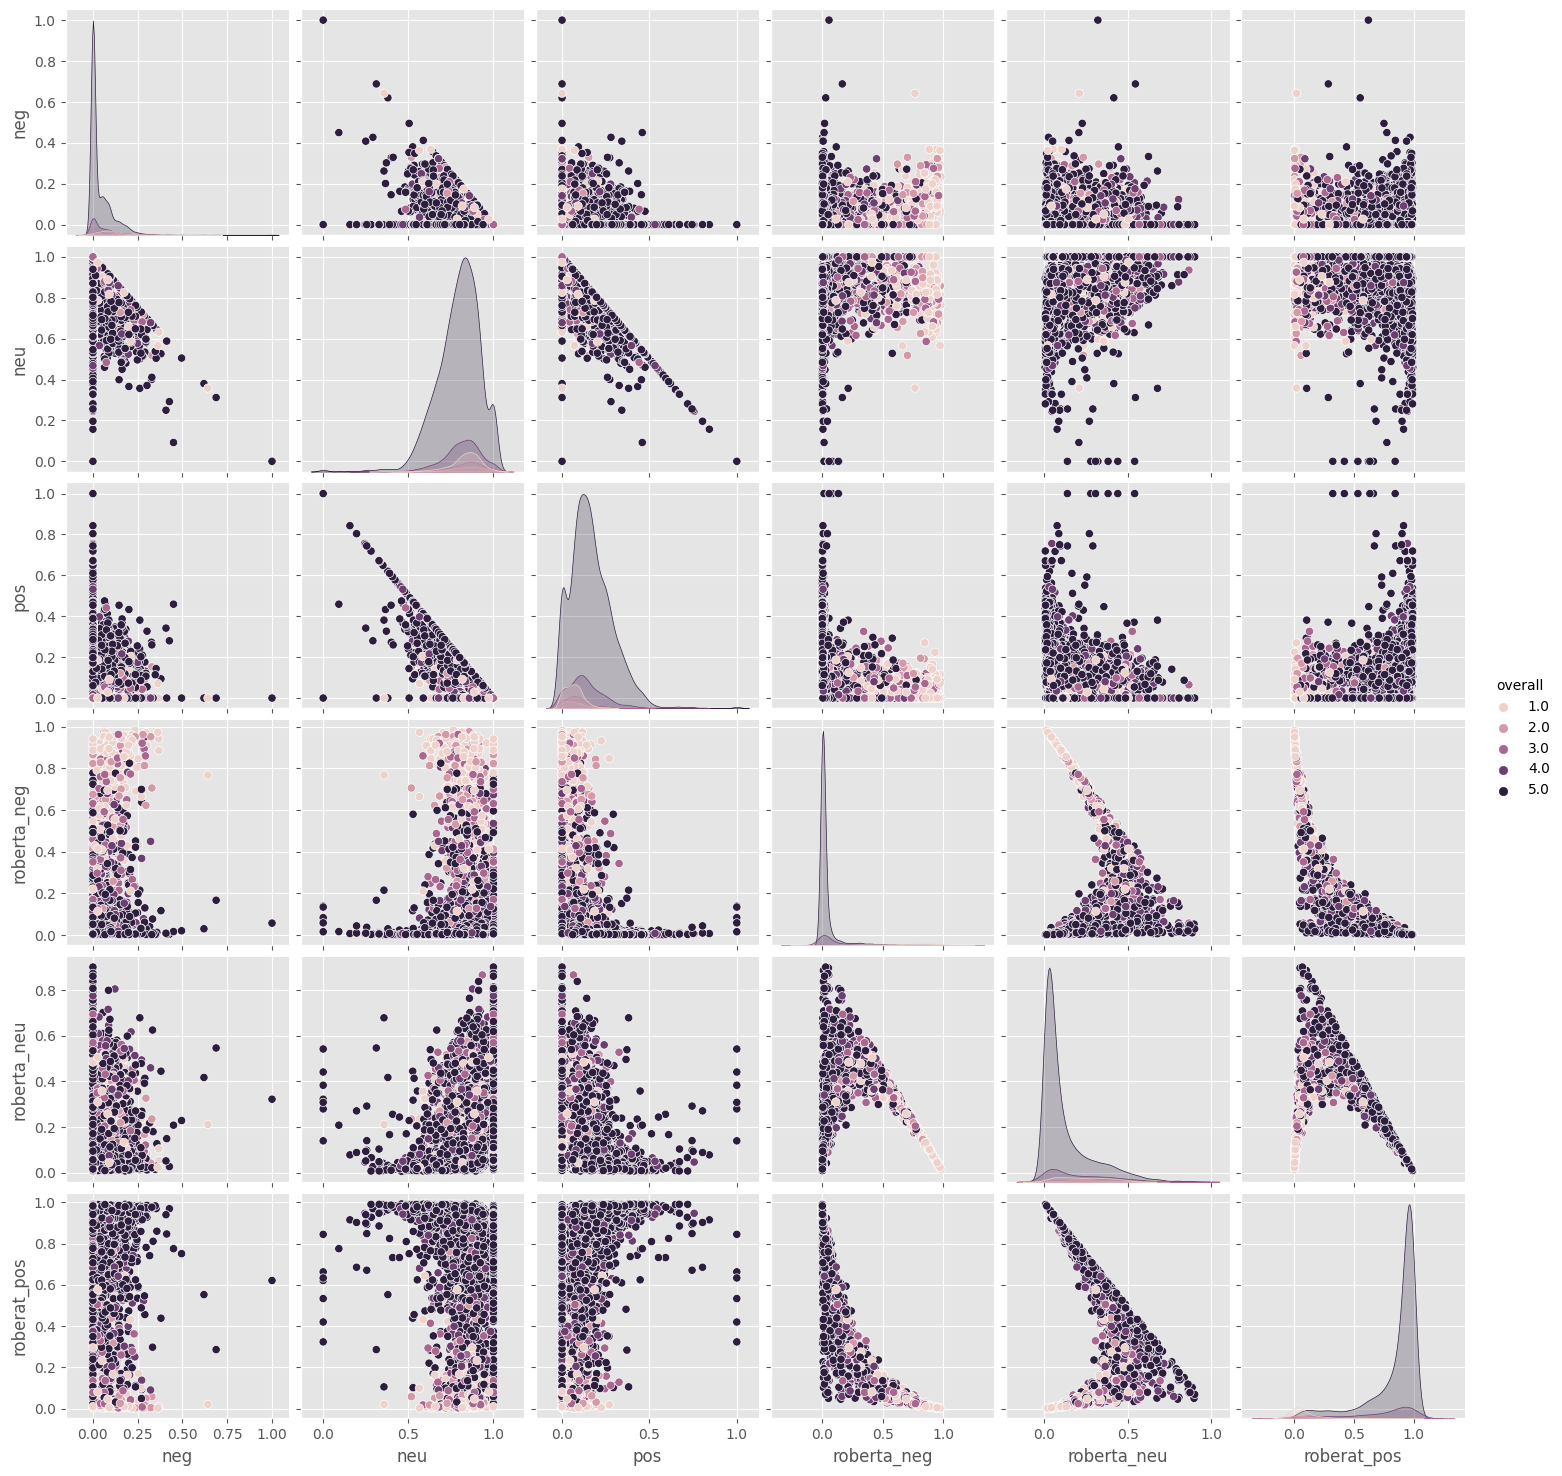

In [35]:
sns.pairplot(data = results, vars = ['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu', 'roberat_pos'], hue = 'overall')
plt.show()

In [36]:
results.query('overall == 1').sort_values('roberat_pos', ascending = False)

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberat_pos,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
4076,4091,0.000,0.822,0.178,0.6369,0.010575,0.088042,0.901383,Scott,1.0,i returned to order a 11.6 laptop so i could h...,2014-08-05,125,0,2,2,-2,0.0,0.000000
1884,1890,0.109,0.792,0.099,-0.1548,0.015830,0.086305,0.897865,gt,1.0,"i have zero complaints, this card does exactly...",2012-04-11,971,0,0,0,0,0.0,0.000000
3383,3395,0.000,0.910,0.090,0.8555,0.061596,0.207292,0.731112,Neacsu Teodor,1.0,i can say that sandisk is one of the best comp...,2014-06-14,177,0,0,0,0,0.0,0.000000
1785,1791,0.047,0.754,0.199,0.9283,0.078627,0.200886,0.720487,G. Evans,1.0,i didn't even have this card installed in my ...,2013-03-23,625,4,1,5,3,0.8,0.375535
173,177,0.000,0.863,0.137,0.8286,0.067670,0.237007,0.695323,"Amazon Customer ""Christian""",1.0,"i routinely use sdxc cards up to 128gb, and th...",2013-05-22,565,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,2385,0.296,0.704,0.000,-0.8777,0.971834,0.025117,0.003049,Joeyd1275,1.0,"im so upset right now it just died , turned on...",2012-11-20,748,0,0,0,0,0.0,0.000000
4829,4849,0.363,0.566,0.071,-0.8687,0.973953,0.023064,0.002983,W. Paul Lothary,1.0,died within 6 months! stopped being able to re...,2014-01-28,314,2,0,2,2,1.0,0.342380
2782,2789,0.219,0.781,0.000,-0.4215,0.961129,0.035940,0.002931,Lateef,1.0,"trash quality, broke and corrupted my data on ...",2014-01-07,335,0,0,0,0,0.0,0.000000
928,933,0.069,0.815,0.116,0.7569,0.974867,0.022398,0.002735,Chris Belardinelli,1.0,i've only had this memory card for 3.5 weeks a...,2013-05-02,585,1,1,2,0,0.5,0.094531


**Examples**

In [37]:
results.query('overall == 1').sort_values('roberat_pos', ascending = False)['reviewText'].values[0]

'i returned to order a 11.6 laptop so i could have full operations than having a notebook. i am sure this is good quality as i have purchased san disk numerous times.'

In [38]:
results.query('overall == 5').sort_values('roberta_neg', ascending = False)['reviewText'].values[0]

'works! and why should i write more..... damn it! eleven more words... finally am done with this, crap!! three more words??'

In [39]:
results.query('overall == 5').sort_values('pos', ascending = False)['reviewText'].values[0]

'super'

In [40]:
results.query('overall == 1').sort_values('neg', ascending = False)['reviewText'].values[0]

'failed after a year!'